[bayesian-ab-testing-in-python](http://www.marcosantoni.com/2016/05/15/bayesian-ab-testing-in-python.html)


- Imagine you re-designing your e-commerce website. You have to decide whether the "Buy Item" button should be blue or green. You decide to setup an A/B test, so you build two versions of the item page:

    - Page A which has a blue button;
    - Page B which has a green button.


## Frequentist vs Bayesian

One could simply approximate the effectiveness of each page by computing the success rate on the two pages. E.g. if N=1000 users visited page A, and 50 of them clicked the button, one could say that the likelihood of clicking the button on page A is 50/1000 \~= 5%. This is the so-called Frequentist approach which envisions the probability in terms of event frequency. However, the following issues might arise on a daily basis:

-    what if N is small (e.g. N=50)? Can we still be confident by just computing the success rate?
-    What if N is different between page A and page B? Let's say that 500 users visited page A and 2000 users visited page B. How can we combine such imbalanced experiments?
-    How large should N be to achieve a 90% confidence in my estimates?

We'll now introduce a simple Bayesian solution that allows to run the A/B test and to handle the issues listed above. The code makes use of PyMC package, and it was inspired by reading "Bayesian Methods for Hackers"  by Cameron Davidson-Pilon.

## Evaluate Page A

We'll first show how to evaluate the success rate on page A with a Bayesian approach. The goal is to infer the probability of clicking the "Buy Item" button on page A. We model this probability as a Bernoulli distribution with parameter $p_{A}$:

$$
P(click|page=A) = \left\{\begin{array}{ll} p_{A} \text{ click = 1 } \\ 1-p_{A} \qquad \text{ click = 0 } \end{array}\right.
$$


So, $p_{A}$ is the parameter indicating the probability of clicking the button on page A. This parameter is unknown and the goal of the experiment is to infer it.

In [6]:
from pymc import Uniform, rbernoulli, Bernoulli, MCMC
from matplotlib import pyplot as plt
import numpy as np

# true value of p_A (unknown)
p_A_true = 0.05
# number of users visiting page A
N = 1500
occurrences = rbernoulli(p_A_true, N)

print ('Click-BUY:')
print (occurrences.sum())
print ('Observed frequency:')
print (occurrences.sum() / float(N))

Click-BUY:
71
Observed frequency:
0.04733333333333333


- In this code, we are simulating a realisation of the experiment where 1500 users visited page A. Here, occurrences indicate how many visitors have actually clicked on the button in this realisation.

- The next step consist of defining our prior on the $p_{A}$ parameter. The prior definition is the first step of Bayesian inference and is a way to indicate our prior belief in the variable

In [7]:
p_A = Uniform('p_A', lower=0, upper=1)
obs = Bernoulli('obs', p_A, value=occurrences, observed=True)

In [8]:
obs

<pymc.distributions.new_dist_class.<locals>.new_class 'obs' at 0x7ffb940e13c8>

- In this section, we define the prior of $p_{a}$ to be a uniform distribution. The obs variable indicates the Bernoulli distribution representing the observations of the click events (indeed governed by the papa parameter). The two variables are assigned to Uniform and Bernoulli which are stochastic variable objects part of PyMC. Each variable is associated with a string name (p_A  and obs in this case). The obs variable has the value  and the observed parameter set because we have observed the realisations of the experiment

In [9]:
# defining a Monte Carlo Markov Chain model
mcmc = MCMC([p_A, obs])
# setting the size of the simulations to 20k particles
mcmc.sample(20000, 1000)
# the resulting posterior distribution is stored in the trace variable
print (mcmc.trace('p_A')[:])

 [-----------------100%-----------------] 20000 of 20000 complete in 1.0 sec[0.0508619  0.0508619  0.0508619  ... 0.05108415 0.05412778 0.04651627]


- In this section, the MCMC model is initialised, and the variables p_A and obs are given to it as input. The sample model will run the Monte Carlo simulations and fit the observed data to the prior belief. The posterior distribution is accessible via the .trace attribute as an array of realisations. We can now visualise the result of the inference.

/home/home9/.virtualenvs/deeplearning/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


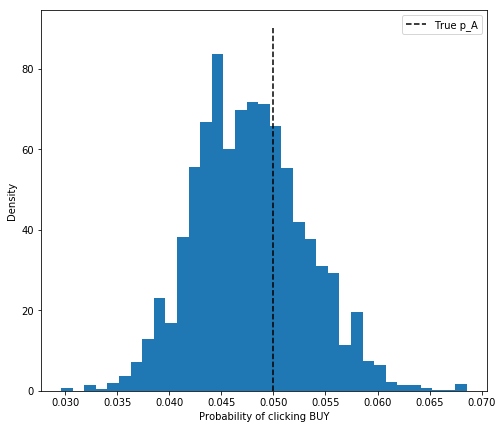

In [10]:
%matplotlib inline
plt.figure(figsize=(8, 7))
plt.hist(mcmc.trace('p_A')[:], bins=35, histtype='stepfilled',
normed=True)
plt.xlabel('Probability of clicking BUY')
plt.ylabel('Density')
plt.vlines(p_A_true, 0, 90, linestyle='--', label='True p_A')
plt.legend()
plt.show()

- Then, we might want to answer the question: where am I 90% confident that the true $p_{A}$ lies? That's easy to answer.

In [13]:
p_A_samples = mcmc.trace('p_A')[:]
lower_bound = np.percentile(p_A_samples, 5)
upper_bound = np.percentile(p_A_samples, 95)
print ('There is 90%% probability that p_A is between {} and {}'.format(lower_bound, upper_bound))

There is 90%% probability that p_A is between 0.03927784537463118 and 0.057105909818956864


## Comparing Page A and Page B

- We'll now repeat what we have done for page A, and we add a new variable delta indicating the difference between $p_{A}$ and $p_{B}$

Observed frequency:
A
0.062
B
0.034666666666666665
 [-----------------100%-----------------] 25000 of 25000 complete in 2.0 sec

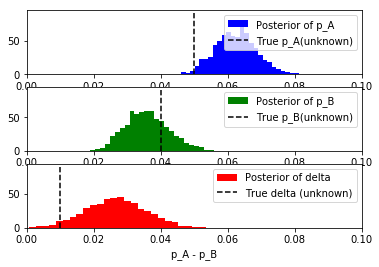

In [15]:
from pymc import Uniform, rbernoulli, Bernoulli, MCMC, deterministic
from matplotlib import pyplot as plt

p_A_true = 0.05
p_B_true = 0.04
N_A = 1500
N_B = 750

occurrences_A = rbernoulli(p_A_true, N_A)
occurrences_B = rbernoulli(p_B_true, N_B)

print ('Observed frequency:')
print ('A')
print (occurrences_A.sum() / float(N_A))
print ('B')
print (occurrences_B.sum() / float(N_B))

p_A = Uniform('p_A', lower=0, upper=1)
p_B = Uniform('p_B', lower=0, upper=1)

@deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

obs_A = Bernoulli('obs_A', p_A, value=occurrences_A, observed=True)
obs_B = Bernoulli('obs_B', p_B, value=occurrences_B, observed=True)

mcmc = MCMC([p_A, p_B, obs_A, obs_B, delta])
mcmc.sample(25000, 5000)

p_A_samples = mcmc.trace('p_A')[:]
p_B_samples = mcmc.trace('p_B')[:]
delta_samples = mcmc.trace('delta')[:]

plt.subplot(3,1,1)
plt.xlim(0, 0.1)
plt.hist(p_A_samples, bins=35, histtype='stepfilled', normed=True,color='blue', label='Posterior of p_A')
plt.vlines(p_A_true, 0, 90, linestyle='--', label='True p_A(unknown)')
plt.xlabel('Probability of clicking BUY via A')
plt.legend()
plt.subplot(3,1,2)
plt.xlim(0, 0.1)
plt.hist(p_B_samples, bins=35, histtype='stepfilled', normed=True,color='green', label='Posterior of p_B')
plt.vlines(p_B_true, 0, 90, linestyle='--', label='True p_B(unknown)')
plt.xlabel('Probability of clicking BUY via B')
plt.legend()
plt.subplot(3,1,3)
plt.xlim(0, 0.1)
plt.hist(delta_samples, bins=35, histtype='stepfilled', normed=True,color='red', label='Posterior of delta')
plt.vlines(p_A_true - p_B_true, 0, 90, linestyle='--', label='True delta (unknown)')
plt.xlabel('p_A - p_B')
plt.legend()
plt.show()

- Then, we can answer a question like: what is the probability that $p_{A}>p_{B}$?

In [18]:
print ('Probability that p_A > p_B:')
print (delta_samples > 0)


Probability that p_A > p_B:
[ True  True  True ...  True  True  True]


In [19]:
delta_true = delta_samples > 0
delta_true.mean()

0.9978